In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar
from scipy import optimize

import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import handtrace
from utils import matrices
from utils import geometry
from utils import mechanics
from utils import visualise

In [3]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R, color):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c=color,alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres, color):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],marker ='o',markersize=2, c=color)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 5,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high

In [6]:
def fk(A0, Ai, Li, dAdr, dLdr, Gamma, L0):
    return (1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1)
def fk_ls(A0, Ai, Li, dAdr, dLdr, Gamma, L0):
    return ((1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1)).flatten()

def objective_k(A0,Ai, Li, dAdr, dLdr, Gamma, L0):

    res = np.linalg.norm(fk(A0,Ai, Li, dAdr, dLdr, Gamma, L0), axis=1).sum()
    return res 

def objective_k_sq(A0,Ai, Li, dAdr, dLdr, Gamma, L0):
    Fk=fk(A0,Ai, Li, dAdr, dLdr, Gamma, L0)
    res = np.array([np.dot(f, f) for f in fk]).sum()
    return res 

def objective_k_av(A0,Ai, Li, dAdr, dLdr, Gamma, L0):
    N=dAdr.shape[1]
    res = np.linalg.norm(fk(A0,Ai, Li, dAdr, dLdr, Gamma, L0), axis=1).sum()/N
    return res 

def cell_energy(A0, Ai, Li, Gamma, L0):
    return 0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2)


def energy(A0, Ai, Li,Gamma, L0):
    return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))

def energy_all(theta, Ai, Li):
    A0, Gamma, L0=theta 
    return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))

NameError: name 'f_fit_minf' is not defined

In [468]:
CURRENT_DIR = os.getcwd()
input_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/'
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/pref_area_test/'

tr_files=sorted(glob(input_dir+'*_trace.tif'))[:]
#for f in tr_files:
f=tr_files[0]
print(f)
edges_name=f.split('\\')[-1].split('.')[0]
exp_id=edges_name.split('_')[0]+'_'+edges_name.split('_')[1]+'_'+edges_name.split('_')[7]

print("Extracing trace data")
edge_verts,cells, cell_edges, A, B, C, R, image0 = handtrace.run_trace(edges_name, input_dir)
#handtrace.check_trace_plot(save_dir,image0, cells, R, edges_name)

micron_size=553.57
pixel_size=1024
t=0


Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
Gamma = 0.172  # Contractility (non-dimensional)
pref_perimeter  = -Lambda/(2*Gamma) 

C:\Users\v35431nc\Documents\Lab_Stuff\Movies_to_track\unstretched/Tracked/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr001_trace.tif
Extracing trace data
955 1390 436


In [49]:
pref_perimeter

0.7529069767441862

In [41]:
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data/*/*_0p5*/*/Matrices'))
#mat_dir[0].split("\\")[-4].split('_G')[0]
mat_dir

['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data\\20231121_1_IN_GFPCAAX-CheHis_uf_8p6\\20231121_1_IN_GFPCAAX-CheHis_uf_0p5_SP_fr001\\2024-04-29_16-25-09\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6\\20231128_1_IP_GFPCAAX-CheHis_uf_0p5_SP_fr001\\2024-04-29_15-27-49\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_0p5_SP_fr001\\2024-05-28_09-37-02\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data\\20240510_1_IN_GFPCAAX-CheHis_uf_8p6\\20240510_1_IN_GFPCAAX-CheHis_uf_0p5_SP_fr001\\2024-05-15_11-09-30\\Matrices']

In [ ]:
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Continuous_data/*/*_0p5*/*/Matrices'))
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/pref_area_test/'

micron_size=553.57
pixel_size=1024

Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
Gamma = 0.172  # Contractility (non-dimensional)
pref_perimeter  = -Lambda/(2*Gamma) 
dat_pa= pd.DataFrame({'method': [], 'pref_area': [], 'P_ext':[], 'total_energy':[], 'sum_fk_mean':[], 'mean_areas_nd':[], 'time':[], 'experiment':[]})


for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cell_areas=geometry.get_areas(A,B, R)
    cell_perimeters=geometry.get_perimeters(A,B,R)
    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    mean_cell_area=geometry.get_mean_area(cell_areas)

    N_c=len(cell_areas)

    tangents=geometry.get_tangents(A,R)
    edge_lengths=geometry.get_edge_lengths(tangents)
    Q,J=mechanics.get_Q_J(tangents, edge_lengths, B,cell_perimeters)

    N_e=len(edge_lengths)
    nij=geometry.get_normals(B,tangents, N_c, N_e)
    dAdr=geometry.get_dAdr(A, nij)
    dLdr=geometry.get_dLdr(A, B, tangents, edge_lengths)

    int_verts=np.ones(len(R))-0.5*(abs(np.ones(N_c)@B))@abs(A)
    ext_verts=0.5*(abs(np.ones(N_c)@B))@abs(A)
    bool_iv=int_verts==1
    bool_ev=ext_verts==1
    edgecells=np.unique(np.where(C[:, bool_ev]!=0)[0])
    intcells=np.array(list(set(np.linspace(0, N_c-1, N_c).astype(int)).difference(edgecells)))

    conT= lambda x: cell_perimeters/np.sqrt(x)
    nlcT = optimize.NonlinearConstraint(conT,pref_perimeter,np.inf)

    conP=lambda x: cell_areas/x 
    nlcP=optimize.NonlinearConstraint(conP,0,1)

    pref_area_P=geometry.get_pref_area(cell_areas, Gamma, cell_perimeters, pref_perimeter, mean_cell_area)
    pref_area_T=np.linalg.det(np.linalg.inv(np.sum((pref_perimeter*cell_perimeters)[:, None, None]*J, axis=0))@np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))
    ls_fk=optimize.least_squares(fk_ls, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), loss="soft_l1", bounds=optimize.Bounds(lb=0, ub=np.inf), jac='3-point', f_scale=0.1)
    min_fk=optimize.minimize(objective_k_sq, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), bounds=optimize.Bounds(lb=0, ub=20000), jac='3-point')

    pref_areas=np.array([pref_area_P, pref_area_T, ls_fk.x[0], min_fk.x[0], min_cons_fk.x[0], min_U.x[0]])
    Pext=np.array([mechanics.GlobalStress(x, cell_areas, Gamma, cell_perimeters, pref_perimeter) for x in pref_areas])
    tot_energy=np.array([energy(x, cell_areas, cell_perimeters, Gamma, pref_perimeter) for x in pref_areas])
    sum_fk_mean=np.array([objective_k(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1] for x in pref_areas])
    mean_areas_nd=np.array([np.mean(cell_areas/x) for x in pref_areas])

    dat_pa_temp= pd.DataFrame({'method': method, 'pref_area': pref_areas, 'P_ext':Pext, 'total_energy':tot_energy, 'sum_fk_mean':sum_fk_mean, 'mean_areas_nd':mean_areas_nd})
    dat_pa_temp['time']=0
    dat_pa_temp['experiment']='con_'+mat_dir[i].split("\\")[-4].split('_G')[0]
    dat_pa=pd.concat([dat_pa, dat_pa_temp])


dat_pa

In [44]:
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Continuous_data/*/*_0p5*/*/Matrices'))
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/pref_area_test/'

micron_size=553.57
pixel_size=1024

Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
Gamma = 0.172  # Contractility (non-dimensional)
pref_perimeter  = -Lambda/(2*Gamma) 
dat_pa= pd.DataFrame({'method': [], 'pref_area': [], 'P_ext':[], 'total_energy':[], 'sum_fk_mean':[], 'mean_areas_nd':[], 'time':[], 'experiment':[]})


for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cell_areas=geometry.get_areas(A,B, R)
    cell_perimeters=geometry.get_perimeters(A,B,R)
    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    mean_cell_area=geometry.get_mean_area(cell_areas)

    N_c=len(cell_areas)

    tangents=geometry.get_tangents(A,R)
    edge_lengths=geometry.get_edge_lengths(tangents)
    Q,J=mechanics.get_Q_J(tangents, edge_lengths, B,cell_perimeters)

    N_e=len(edge_lengths)
    nij=geometry.get_normals(B,tangents, N_c, N_e)
    dAdr=geometry.get_dAdr(A, nij)
    dLdr=geometry.get_dLdr(A, B, tangents, edge_lengths)

    int_verts=np.ones(len(R))-0.5*(abs(np.ones(N_c)@B))@abs(A)
    ext_verts=0.5*(abs(np.ones(N_c)@B))@abs(A)
    bool_iv=int_verts==1
    bool_ev=ext_verts==1
    edgecells=np.unique(np.where(C[:, bool_ev]!=0)[0])
    intcells=np.array(list(set(np.linspace(0, N_c-1, N_c).astype(int)).difference(edgecells)))

    conT= lambda x: cell_perimeters/np.sqrt(x)
    nlcT = optimize.NonlinearConstraint(conT,pref_perimeter,np.inf)

    conP=lambda x: cell_areas/x 
    nlcP=optimize.NonlinearConstraint(conP,0,1)

    pref_area_P=geometry.get_pref_area(cell_areas, Gamma, cell_perimeters, pref_perimeter, mean_cell_area)
    pref_area_T=np.linalg.det(np.linalg.inv(np.sum((pref_perimeter*cell_perimeters)[:, None, None]*J, axis=0))@np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))
    ls_fk=optimize.least_squares(fk_ls, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), loss="soft_l1", bounds=optimize.Bounds(lb=0, ub=np.inf), jac='3-point', f_scale=0.1)
    min_fk=optimize.minimize(objective_k, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), bounds=optimize.Bounds(lb=0, ub=20000), jac='3-point')
    min_cons_fk=optimize.minimize(objective_k, x0=mean_cell_area, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=np.inf), constraints=[nlcP, nlcT])
    min_U=optimize.basinhopping(energy, x0=mean_cell_area,minimizer_kwargs={"args":( cell_areas, cell_perimeters, Gamma, pref_perimeter),"bounds":optimize.Bounds(lb=0, ub=20000)}, niter=1000)

    method=np.array(["zero_iso_stress", "zero_dev_stress", "int_vert_force_ls", "min_sum_int_vert", "cons_min_sum_int_verts", "min_energy"])
    pref_areas=np.array([pref_area_P, pref_area_T, ls_fk.x[0], min_fk.x[0], min_cons_fk.x[0], min_U.x[0]])
    Pext=np.array([mechanics.GlobalStress(x, cell_areas, Gamma, cell_perimeters, pref_perimeter) for x in pref_areas])
    tot_energy=np.array([energy(x, cell_areas, cell_perimeters, Gamma, pref_perimeter) for x in pref_areas])
    sum_fk_mean=np.array([objective_k(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1] for x in pref_areas])
    mean_areas_nd=np.array([np.mean(cell_areas/x) for x in pref_areas])

    dat_pa_temp= pd.DataFrame({'method': method, 'pref_area': pref_areas, 'P_ext':Pext, 'total_energy':tot_energy, 'sum_fk_mean':sum_fk_mean, 'mean_areas_nd':mean_areas_nd})
    dat_pa_temp['time']=0
    dat_pa_temp['experiment']='con_'+mat_dir[i].split("\\")[-4].split('_G')[0]
    dat_pa=pd.concat([dat_pa, dat_pa_temp])


dat_pa

,method,pref_area,P_ext,total_energy,sum_fk_mean,mean_areas_nd,time,experiment
0,zero_iso_stress,1583.387227,6.162578e-17,184.228102,0.104107,0.224843,0.0,con_20240412_2_IP
1,zero_dev_stress,8828.278133,-9.097548e-01,210.341001,0.038421,0.040326,0.0,con_20240412_2_IP
2,int_vert_force_ls,7905.022797,-8.382273e-01,208.465904,0.038612,0.045036,0.0,con_20240412_2_IP
3,min_sum_int_vert,8629.325229,-8.947375e-01,209.958499,0.038409,0.041256,0.0,con_20240412_2_IP
4,cons_min_sum_int_verts,3313.059271,-3.588188e-01,192.687922,0.060881,0.107457,0.0,con_20240412_2_IP
5,min_energy,1583.402939,-4.971895e-06,184.228102,0.104107,0.224840,0.0,con_20240412_2_IP
0,zero_iso_stress,1649.200345,0.000000e+00,167.489438,0.100140,0.221269,0.0,con_20240503_2_IP
1,zero_dev_stress,7033.856592,-7.458830e-01,186.769283,0.044274,0.051880,0.0,con_20240503_2_IP
2,int_vert_force_ls,7749.620992,-8.050626e-01,188.302631,0.043691,0.047088,0.0,con_20240503_2_IP
3,min_sum_int_vert,8511.086039,-8.643820e-01,189.753864,0.043507,0.042875,0.0,con_20240503_2_IP


In [45]:
dat_pa.to_csv(save_dir+"/pref_area_analysis_continuous.csv",index=False)
pa_con=dat_pa

In [20]:
pa_uns=pd.concat([pa_uns_20231012_2_IP, pa_uns_20231019_1_IP, pa_uns_20240117_2_IP])
pa_uns.to_csv(save_dir+"/pref_area_analysis_unstretched.csv",index=False)

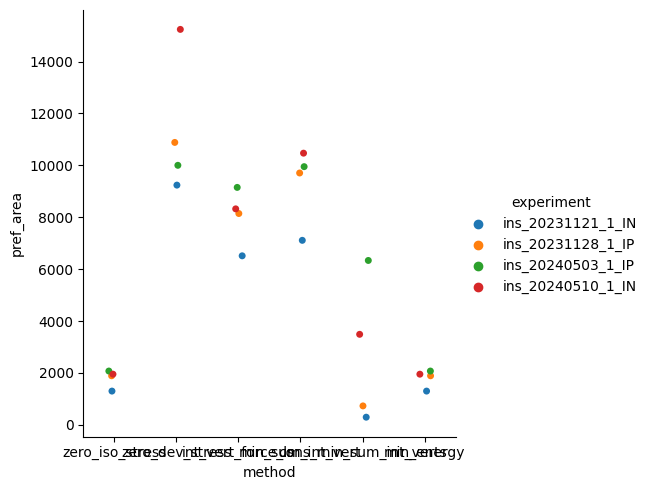

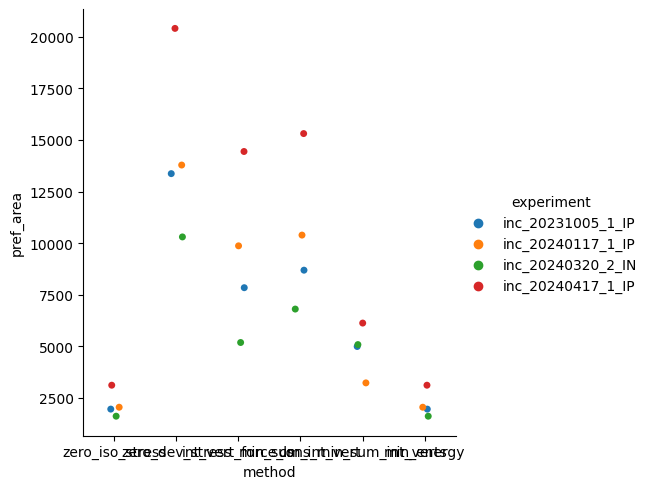

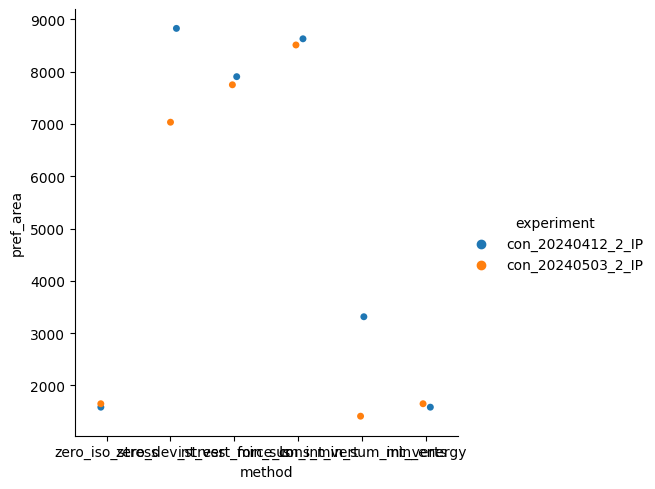

In [50]:
sns.catplot(pa_ins, x='method', y='pref_area', hue='experiment')
plt.show()
sns.catplot(pa_inc, x='method', y='pref_area', hue='experiment')
plt.show()
sns.catplot(pa_con, x='method', y='pref_area', hue='experiment')

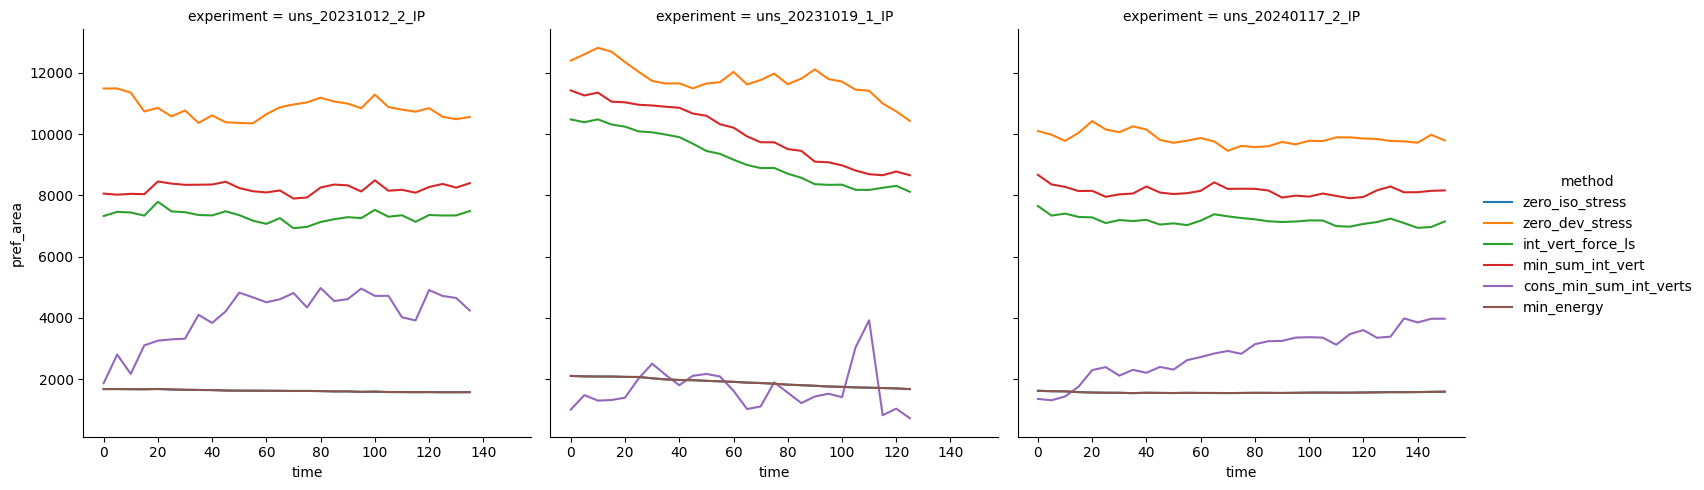

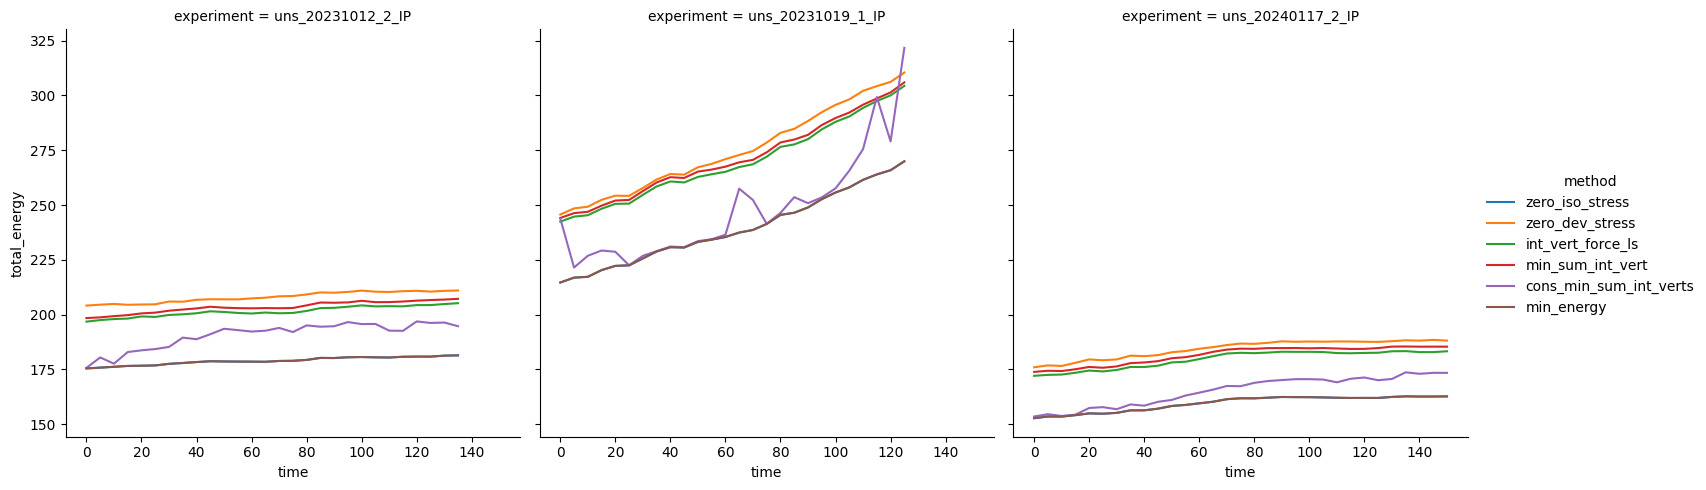

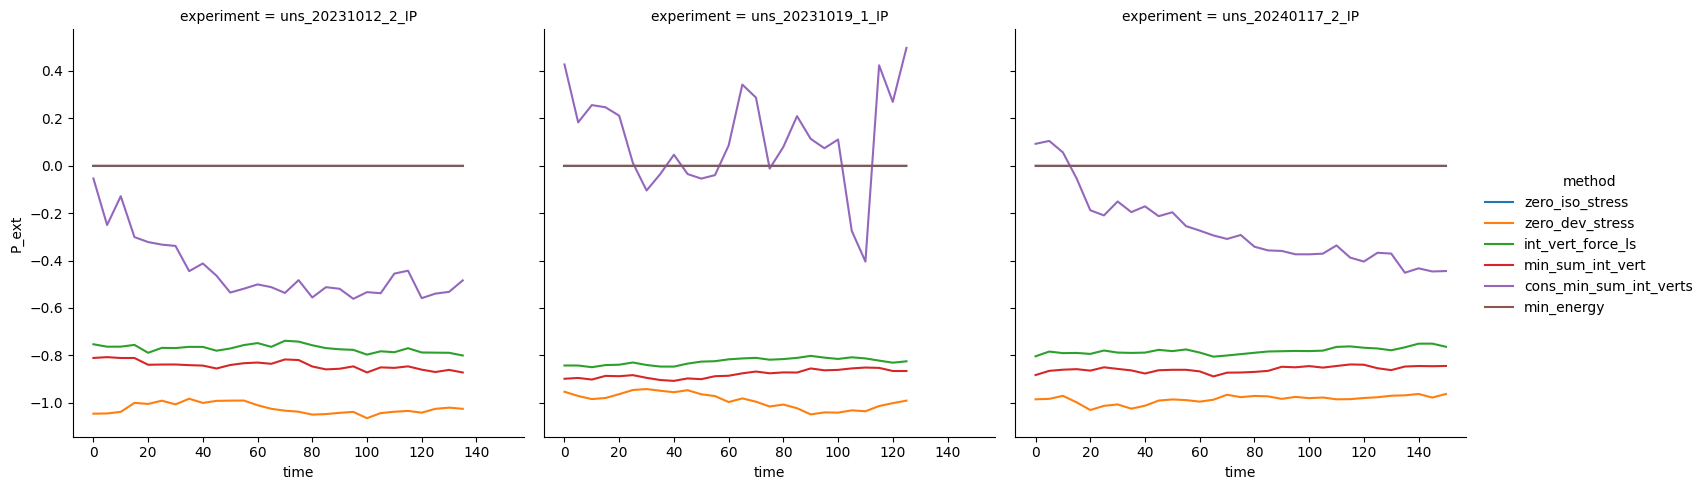

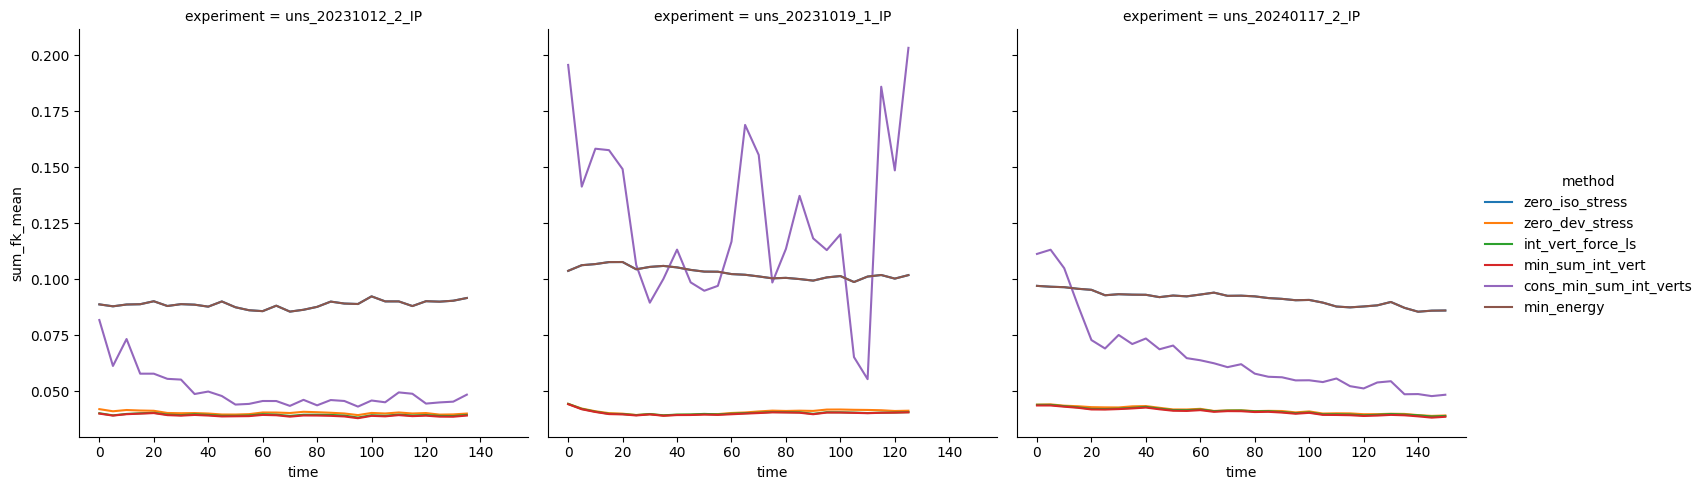

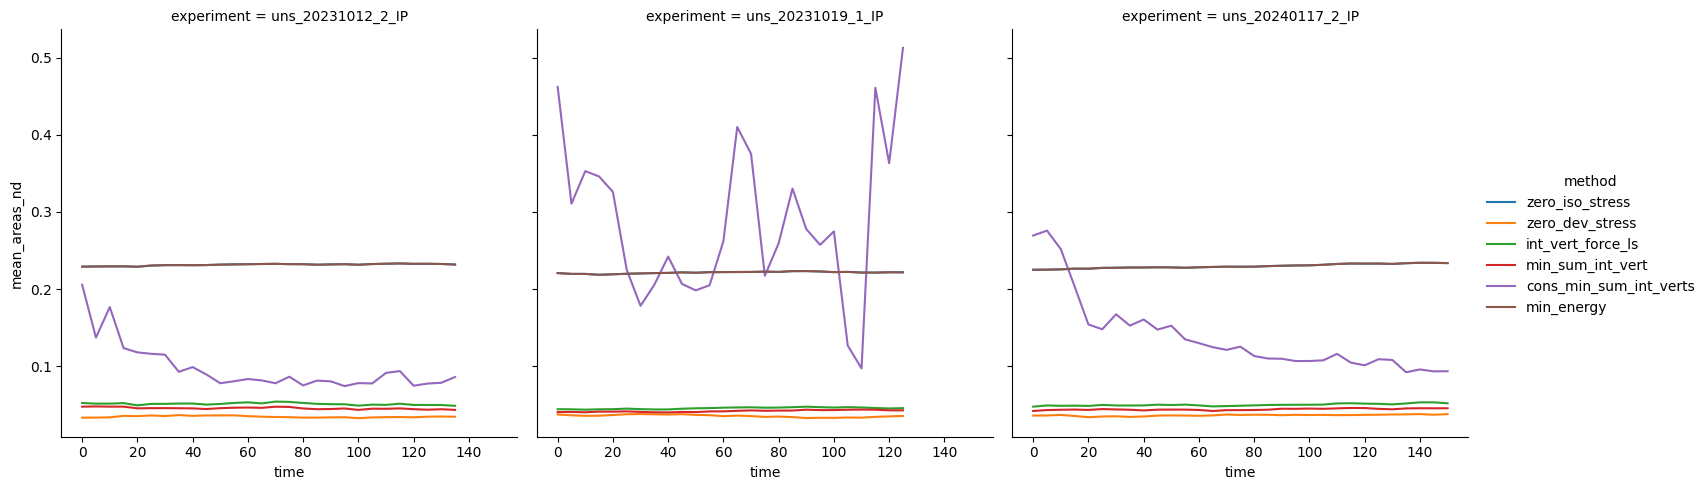

In [51]:
sns.relplot(pa_uns, x='time', y='pref_area', hue='method', col='experiment', kind='line')
sns.relplot(pa_uns, x='time', y='total_energy', hue='method', col='experiment', kind='line')
sns.relplot(pa_uns, x='time', y='P_ext', hue='method', col='experiment', kind='line')
sns.relplot(pa_uns, x='time', y='sum_fk_mean', hue='method', col='experiment', kind='line')
sns.relplot(pa_uns, x='time', y='mean_areas_nd', hue='method', col='experiment', kind='line')

1674.938735448252


c:\Users\v35431nc\Documents\Lab_Stuff\Code\tissue_image_analysis\tissue_image_analysis\proccess_tracked_movies\..\utils\mechanics.py:15: RuntimeWarning: divide by zero encountered in divide
  globalStress = np.sum(((A/pref_area) - 1 + 0.5*Gamma*(L/A)*(L - L_0*(pref_area**(1/2))))*A)/np.sum(A);


Text(0.5, 0, '$A_0^*$')

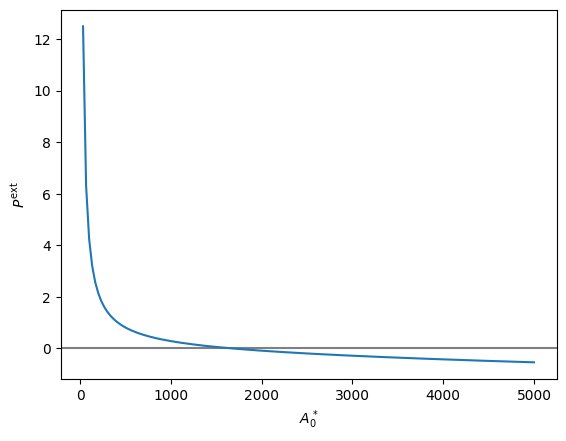

In [472]:
pref_area_P=geometry.get_pref_area(cell_areas, Gamma, cell_perimeters, pref_perimeter, mean_cell_area)
print(pref_area_P)
pts=np.linspace(0, 5000, 150)
plt.plot(pts,np.array([mechanics.GlobalStress(x, cell_areas, Gamma, cell_perimeters, pref_perimeter)for x in pts]))
plt.axhline(0, color='grey', zorder=0)
plt.ylabel(r"$P^{\mathrm{ext}}$")
plt.xlabel(r"$A_0^*$")

Prefered area =  11492.75605978718


Text(0.5, 0, '$A_0^*$')

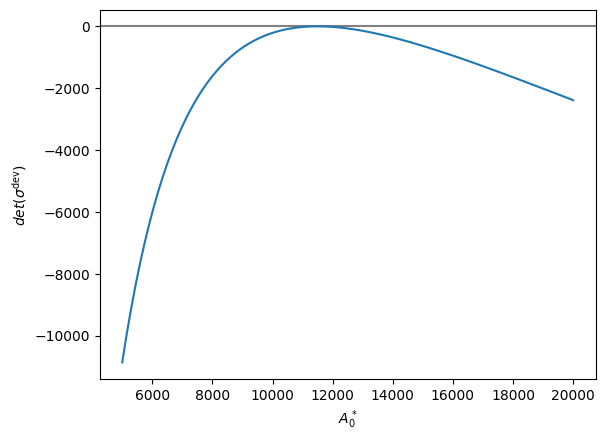

In [473]:
#pref_area_T=np.linalg.det(np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))/((pref_perimeter*pref_perimeter)*np.linalg.det(np.sum((cell_perimeters)[:, None, None]*J, axis=0)))

pref_area_T=np.linalg.det(np.linalg.inv(np.sum((pref_perimeter*cell_perimeters)[:, None, None]*J, axis=0))@np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))
print("Prefered area = ", pref_area_T)


def T_func(A0, L, L0, J):
    return np.sum(((L*L)/np.sqrt(A0) - L0*L)[:, None, None]*J, axis=0)

pts=np.linspace(5000, 20000, 200)
plt.plot(pts,np.array([np.linalg.det(T_func(x, cell_perimeters, pref_perimeter, J)) for x in pts]))
plt.axhline(0, color='grey', zorder=0)
plt.ylabel(r"$det(\sigma^{\mathrm{dev}})$")
plt.xlabel(r"$A_0^*$")

In [325]:
dAdr[:, bool_iv][intcells].shape[1]

782

In [474]:
ls_fk=optimize.least_squares(fk_ls, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), loss="soft_l1", bounds=optimize.Bounds(lb=0, ub=np.inf), jac='3-point', f_scale=0.1)
print(ls_fk.x)
print(ls_fk.cost)

[7328.07258884]
0.9182235378791318


In [475]:
min_fk=optimize.minimize(objective_k, x0=mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), bounds=optimize.Bounds(lb=0, ub=20000), jac='3-point')
print(min_fk.x)
print(min_fk.fun)
min_fk

[8059.92937526]
31.21789595250975


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 31.21789595250975
        x: [ 8.060e+03]
      nit: 15
      jac: [-8.243e-06]
     nfev: 48
     njev: 16
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [476]:
min_fk_av=optimize.minimize(objective_k_av, x0=4.45*mean_cell_area, args=(cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:,bool_iv][intcells], Gamma, pref_perimeter), bounds=optimize.Bounds(lb=0, ub=np.inf), jac='3-point')
print(min_fk_av.x)
print(min_fk_av.fun)
min_fk_av

[1706.95160374]
0.08740807235748209


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.08740807235748209
        x: [ 1.707e+03]
      nit: 1
      jac: [-3.949e-05]
     nfev: 6
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [477]:
conT= lambda x: cell_perimeters/np.sqrt(x)
nlcT = optimize.NonlinearConstraint(conT,pref_perimeter,np.inf)

conP=lambda x: cell_areas/x 
nlcP=optimize.NonlinearConstraint(conP,0,1)


conT_all= lambda x: cell_perimeters/np.sqrt(x[0])-x[2]
nlcT_all = optimize.NonlinearConstraint(conT_all,0,np.inf)

conP_all=lambda x: cell_areas/x[0] 
nlcP_all=optimize.NonlinearConstraint(conP_all,0,1)

In [481]:
min_cons_fk=optimize.minimize(objective_k, x0=mean_cell_area, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=np.inf), constraints=[nlcP, nlcT])

print(min_cons_fk.x)
print(min_cons_fk.fun)

min_cons_fk

[1865.51256295]
63.90158401426042


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 63.90158401426042
       x: [ 1.866e+03]
     nit: 13
     jac: [-2.556e-02]
    nfev: 26
    njev: 13

In [479]:
min_cons_fk_av=optimize.minimize(objective_k_av, x0=4.45*mean_cell_area, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=np.inf), constraints=[nlcP, nlcT])

print(min_cons_fk_av.x)
print(min_cons_fk_av.fun)

min_cons_fk_av

[1706.95156425]
0.08740807391727652


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.08740807391727652
       x: [ 1.707e+03]
     nit: 1
     jac: [-3.950e-05]
    nfev: 2
    njev: 1

In [357]:
optimize.basinhopping(objective_k, x0=4.45*mean_cell_area,minimizer_kwargs={"args":( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter), "method":"SLSQP","bounds":optimize.Bounds(lb=0, ub=np.inf), "constraints":[nlcP, nlcT]})

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 63.901583978259566
                          x: [ 1.866e+03]
                        nit: 100
      minimization_failures: 0
                       nfev: 648
                       njev: 314
 lowest_optimization_result: message: Optimization terminated successfully
                             success: True
                              status: 0
                                 fun: 63.901583978259566
                                   x: [ 1.866e+03]
                                 nit: 3
                                 jac: [-2.556e-02]
                                nfev: 6
                                njev: 3

In [480]:
min_U=optimize.basinhopping(energy, x0=mean_cell_area,minimizer_kwargs={"args":( cell_areas, cell_perimeters, Gamma, pref_perimeter), "method":"SLSQP","bounds":optimize.Bounds(lb=0, ub=20000), "constraints":[nlcP, nlcT]}, niter=1000)
min_U

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 175.4534150841056
                          x: [ 1.675e+03]
                        nit: 1000
      minimization_failures: 0
                       nfev: 2030
                       njev: 1015
 lowest_optimization_result: message: Optimization terminated successfully
                             success: True
                              status: 0
                                 fun: 175.4534150841056
                                   x: [ 1.675e+03]
                                 nit: 1
                                 jac: [ 0.000e+00]
                                nfev: 2
                                njev: 1

In [7]:
min_U=optimize.basinhopping(energy, x0=mean_cell_area,minimizer_kwargs={"args":( cell_areas, cell_perimeters, Gamma, pref_perimeter),"bounds":optimize.Bounds(lb=0, ub=20000)}, niter=1000)
min_U

NameError: name 'mean_cell_area' is not defined

In [461]:
optimize.basinhopping(energy_all, x0=[mean_cell_area, Gamma, pref_perimeter],minimizer_kwargs={"args":( cell_areas, cell_perimeters), "method":"SLSQP","bounds":optimize.Bounds(lb=[0, 0, 0], ub=[20000, 5, 3.81]), "constraints":[nlcP_all, nlcT_all]}, niter=1000)

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\439295351.py:25: RuntimeWarning: divide by zero encountered in divide
  return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\439295351.py:25: RuntimeWarning: invalid value encountered in multiply
  return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\937042919.py:11: RuntimeWarning: divide by zero encountered in divide
  conP_all=lambda x: cell_areas/x[0]
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\937042919.py:8: RuntimeWarning: divide by zero encountered in divide
  conT_all= lambda x: cell_perimeters/np.sqrt(x[0])-x[2]


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 94.81091539328492
                          x: [ 1.118e+03  0.000e+00  0.000e+00]
                        nit: 1000
      minimization_failures: 9
                       nfev: 20764
                       njev: 4326
 lowest_optimization_result: message: Optimization terminated successfully
                             success: True
                              status: 0
                                 fun: 94.81091539328492
                                   x: [ 1.118e+03  0.000e+00  0.000e+00]
                                 nit: 8
                                 jac: [ 1.071e-01  1.641e+03  0.000e+00]
                                nfev: 16
                                njev: 4

In [429]:
res=optimize.shgo(energy_all, args=( cell_areas, cell_perimeters),bounds=optimize.Bounds(lb=[0, 0.05, 0], ub=[20000, 5, 3.81]),sampling_method='sobol')
res

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\439295351.py:25: RuntimeWarning: divide by zero encountered in divide
  return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))


 message: Optimization terminated successfully.
 success: True
     fun: 17.574825680591495
    funl: [ 1.757e+01  1.757e+01  1.757e+01  1.757e+01  1.757e+01
            1.757e+01  1.757e+01]
       x: [ 4.148e+02  5.000e-02  3.666e+00]
      xl: [[ 4.148e+02  5.000e-02  3.666e+00]
           [ 4.148e+02  5.000e-02  3.666e+00]
           ...
           [ 4.148e+02  5.000e-02  3.666e+00]
           [ 4.148e+02  5.000e-02  3.666e+00]]
     nit: 1
    nfev: 1269
   nlfev: 1147
   nljev: 267
   nlhev: 0

In [399]:
optimize.shgo(energy, args=( cell_areas[intcells], cell_perimeters[intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=20000))

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\3996564548.py:21: RuntimeWarning: divide by zero encountered in divide
  return np.sum(0.5*((Ai/A0 -1)**2 +Gamma*(Li/np.sqrt(A0) - L0)**2))


 message: Optimization terminated successfully.
 success: True
     fun: 140.4283132574909
    funl: [ 1.404e+02]
       x: [ 1.683e+03]
      xl: [[ 1.683e+03]]
     nit: 1
    nfev: 70
   nlfev: 67
   nljev: 27
   nlhev: 0

In [338]:
optimize.dual_annealing(objective_k_av,bounds=optimize.Bounds(lb=0, ub=20000), args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),minimizer_kwargs={"method":"SLSQP", "constraints":[nlcP, nlcT]}, maxiter=100000)

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\2335431399.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1)
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_3508\937042919.py:1: RuntimeWarning: invalid value encountered in sqrt
  conT= lambda x: cell_perimeters/np.sqrt(x)


KeyboardInterrupt: 

In [438]:
optimize.minimize(objective_k, x0=mean_cell_area, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=np.inf), constraints=[nlcP, nlcT], method='trust-constr',options={'verbose':3}, jac='3-point')

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   3   |   0   | +2.9127e+02 | 1.00e+00 | 8.67e-01 | 9.84e-01 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   6   |   1   | +2.9101e+02 | 5.90e+00 | 8.68e-01 | 9.83e-01 | 1.00e+00 |  1.00e-01   |   1   |
|   3   |   9   |   2   | +2.8794e+02 | 4.13e+01 | 8.35e-01 | 9.65e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   4   |  12   |   3   | +2.5672e+02 | 2.89e+02 | 6.51e-01 | 7.76e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  15   |   4   | +1.9466e+02 | 8.70e+02 | 3.22e-01 | 3.78e-01 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |  18   |   5   | +1.6006e+02 | 8.70e+02 | 1.91e-01 | 1.40e-01 | 1.00e+00 |  1.00e-01   |   1   |
|   7   |  21   |   6   | +1.3366e+02 | 9.21e+02 | 1.11e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   8   |  24   |   7   | +1.1634e+02 | 9.21e+

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 63.90174411158509
                 x: [ 1.866e+03]
               nit: 23
              nfev: 57
              njev: 19
              nhev: 0
          cg_niter: 18
      cg_stop_cond: 1
              grad: [-2.556e-02]
   lagrangian_grad: [ 1.825e-09]
            constr: [array([ 2.624e-02,  1.582e-01, ...,  2.099e-01,
                            3.876e-01]), array([ 7.529e-01,  1.667e+00, ...,  1.801e+00,
                            2.505e+00]), array([ 1.866e+03])]
               jac: [array([[-1.407e-05],
                           [-8.482e-05],
                           ...,
                           [-1.125e-04],
                           [-2.078e-04]]), array([[-2.018e-04],
                           [-4.469e-04],
                           ...,
                           [-4.828e-04],
                           [-6.715e-04]]), array([[ 1.000e+00]]

Text(0.5, 0, '$A_0^*$')

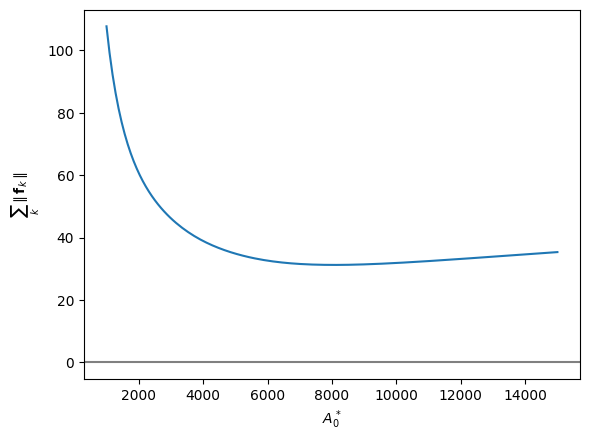

In [361]:
pts=np.linspace(1000, 15000, 150)
plt.plot(pts,np.array([objective_k(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter )for x in pts]))
plt.axhline(0, color='grey', zorder=0)
plt.ylabel(r"$\sum_k \parallel \mathbf{f}_k\parallel$")
plt.xlabel(r"$A_0^*$")

Text(0.5, 0, '$A_0^*$')

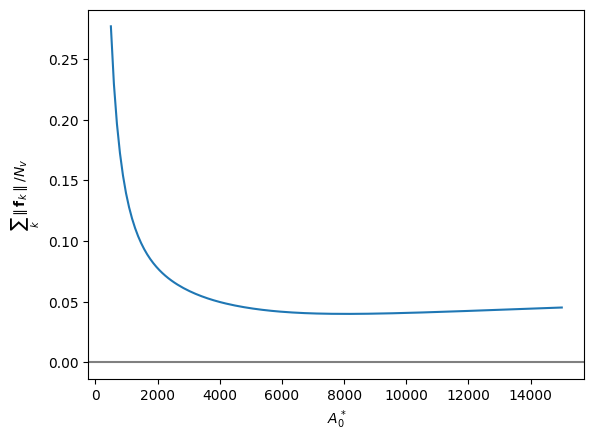

In [362]:
pts=np.linspace(500, 15000, 150)
plt.plot(pts,np.array([objective_k_av(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter )for x in pts]))
plt.axhline(0, color='grey', zorder=0)
plt.ylabel(r"$\sum_k \parallel \mathbf{f}_k\parallel / N_v$")
plt.xlabel(r"$A_0^*$")

Text(0.5, 0, '$A_0^*$')

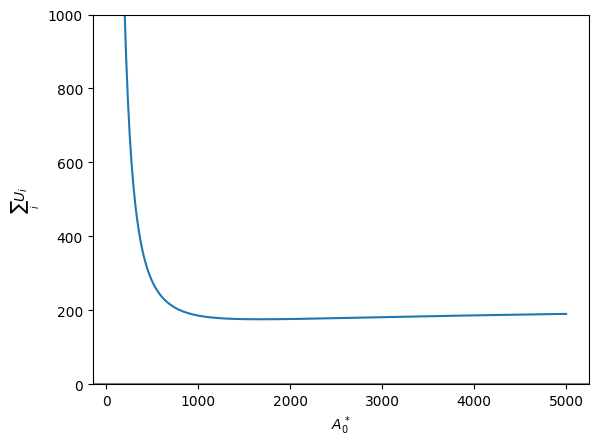

In [400]:
pts=np.linspace(100, 5000, 500)
plt.plot(pts,np.array([energy(x,cell_areas, cell_perimeters, Gamma, pref_perimeter )for x in pts]))
plt.axhline(0, color='grey', zorder=0)
plt.ylim(0, 1000)
plt.ylabel(r"$\sum_i U_i$")
plt.xlabel(r"$A_0^*$")

In [482]:
print(mechanics.GlobalStress(pref_area_P, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(pref_area_T, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(min_fk.x, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(min_cons_fk.x, cell_areas, Gamma, cell_perimeters, pref_perimeter))

print(mechanics.GlobalStress(min_U.x, cell_areas, Gamma, cell_perimeters, pref_perimeter))


print(mechanics.GlobalStress(ls_fk.x, cell_areas, Gamma, cell_perimeters, pref_perimeter))

3.534808200607436e-17
-1.045766307024541
-0.8108237691963285
-0.0537138214920689
9.812150886102927e-07
-0.753115838402772


In [483]:
print(objective_k(pref_area_P,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1])
print(objective_k(pref_area_T, cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1])

print(objective_k(min_fk.x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1])
print(objective_k(min_cons_fk.x, cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter)/dAdr[:, bool_iv][intcells].shape[1])

0.08869907922244927
0.04192149806956611
0.039920583059475385
0.08171558058089567


In [485]:

print(energy(pref_area_P, cell_areas, cell_perimeters, Gamma, pref_perimeter))
print(energy(pref_area_T, cell_areas, cell_perimeters, Gamma, pref_perimeter))
print(energy(min_fk.x, cell_areas, cell_perimeters, Gamma, pref_perimeter))
print(energy(min_cons_fk.x, cell_areas, cell_perimeters, Gamma, pref_perimeter))


175.45341508401026
204.11305215324134
198.41980061267572
175.7234416583529


In [484]:

print(np.mean(cell_areas/pref_area_P))
print(np.mean(cell_areas/pref_area_T))
print(np.mean(cell_areas/min_fk.x))
print(np.mean(cell_areas/min_cons_fk.x))

print(np.mean(cell_areas/min_U.x))


print(np.mean(cell_areas/ls_fk.x))

0.22901412037387017
0.03337620838581576
0.047591561081951936
0.2056188893056475
0.22901456606228895
0.052344544425384026


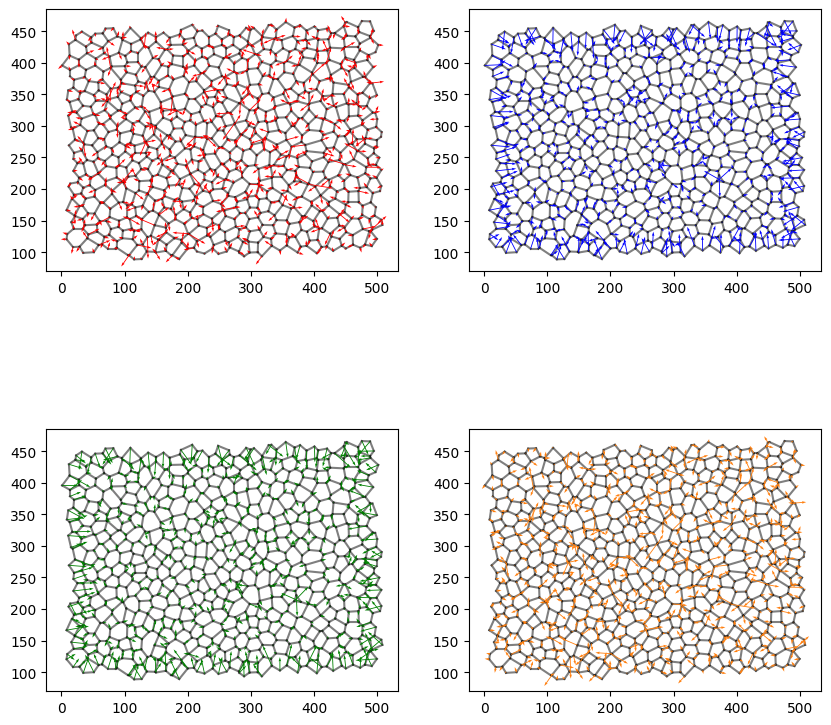

In [403]:
f_fit_P=fk(pref_area_P, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_T=fk(pref_area_T, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)

f_fit_f=fk(min_fk.x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_cons_f=fk(min_cons_fk.x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)


f_fit_fls=fk(ls_fk.x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)


fig, ax=plt.subplots(2,2,subplot_kw={'aspect': 'equal'}, figsize=(10,10))

N_e=np.shape(A)[0]
beg_edge = ((abs(A) - A)*0.5)@R
end_edge = ((abs(A) + A)*0.5)@R
for j in range(0,N_e):
    ax[0,0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[0,0].quiver(R[:,0], R[:,1], f_fit_P[:,0], f_fit_P[:,1], color='red')

for j in range(0,N_e):
    ax[0,1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)
ax[0,1].quiver(R[:,0], R[:,1], f_fit_T[:,0], f_fit_T[:,1], color='blue')

for j in range(0,N_e):
    ax[1,0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[1,0].quiver(R[:,0], R[:,1], f_fit_f[:,0], f_fit_f[:,1], color='green')

for j in range(0,N_e):
    ax[1,1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[1,1].quiver(R[:,0], R[:,1], f_fit_cons_f[:,0], f_fit_cons_f[:,1], color='tab:orange')

In [404]:
print("mean = ",np.mean(np.linalg.norm(f_fit_P, axis=1)), ", min = ", np.min(np.linalg.norm(f_fit_P, axis=1)), ", max = ", np.max(np.linalg.norm(f_fit_P, axis=1)))
print("mean = ",np.mean(np.linalg.norm(f_fit_T, axis=1)), ", min = ", np.min(np.linalg.norm(f_fit_T, axis=1)), ", max = ", np.max(np.linalg.norm(f_fit_T, axis=1)))
print("mean = ",np.mean(np.linalg.norm(f_fit_f, axis=1)), ", min = ", np.min(np.linalg.norm(f_fit_f, axis=1)), ", max = ", np.max(np.linalg.norm(f_fit_f, axis=1)))
print("mean = ",np.mean(np.linalg.norm(f_fit_cons_f, axis=1)), ", min = ", np.min(np.linalg.norm(f_fit_cons_f, axis=1)), ", max = ", np.max(np.linalg.norm(f_fit_cons_f, axis=1)))

mean =  0.09054139361667686 , min =  0.0014326137647228507 , max =  0.36353920730029704
mean =  0.04082788426700793 , min =  0.0006748037502565443 , max =  0.1532256474308622
mean =  0.03912513461653323 , min =  0.0006785767206339407 , max =  0.1466831922759391
mean =  0.08349065682293932 , min =  0.0041694185546958815 , max =  0.33388124780540307


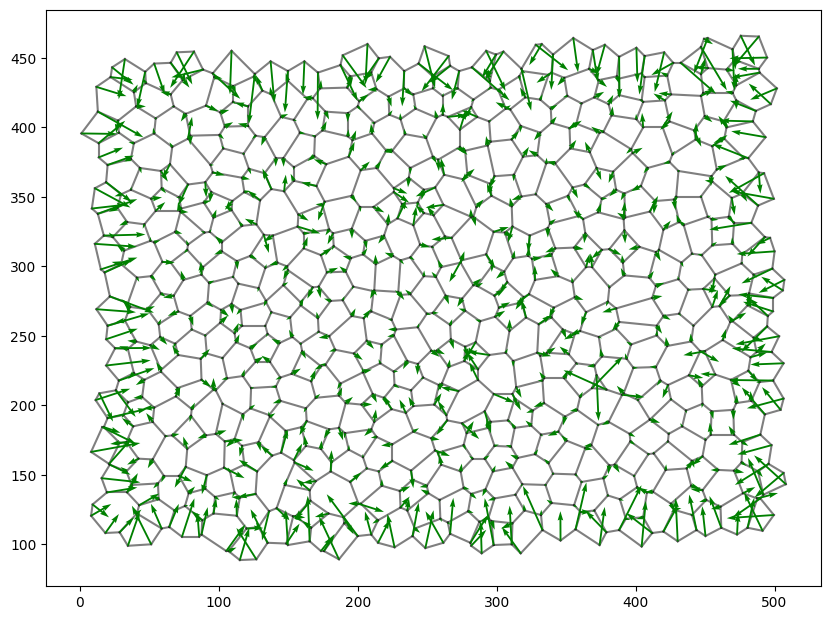

In [487]:

fig, ax=plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(10,8))

N_e=np.shape(A)[0]
beg_edge = ((abs(A) - A)*0.5)@R
end_edge = ((abs(A) + A)*0.5)@R
for j in range(0,N_e):
    ax.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax.quiver(R[:,0], R[:,1], f_fit_f[:,0], f_fit_f[:,1], color='green')

175.45341508417806

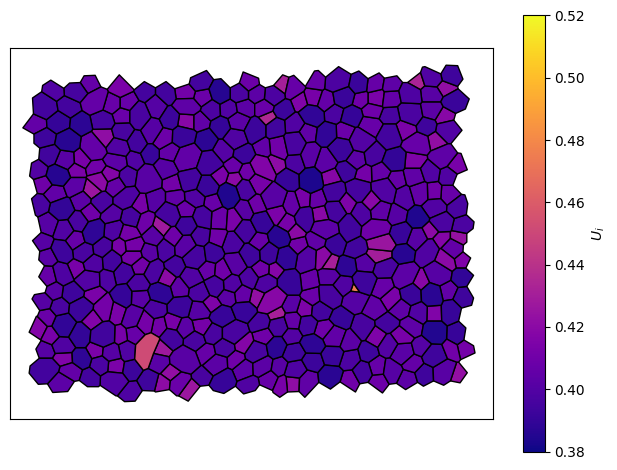

In [496]:
    plot_variable=cell_energy(min_cons_fk.x, cell_areas, cell_perimeters, Gamma, pref_perimeter)
    cmap='plasma'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(cell_centres[:,0].min()-30, cell_centres[:,0].max()+30)
    ax.set_ylim(cell_centres[:,1].min()-30,cell_centres[:,1].max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cell_centres)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0.38, 0.52)
    polys.set_edgecolor('black')
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel(r'$U_i$', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)


   

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

In [352]:
np.linalg.norm(f_fit_P)

4.542156219503129

In [492]:
np.max(cell_energy(pref_area_T, cell_areas, cell_perimeters, Gamma, pref_perimeter))

0.5131313684503302